In [1]:

from sklearn import mixture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from comp_analysis_cluster import read_rrng
import os
from mpl_toolkits import mplot3d
from scipy import stats
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy.stats import norm
import  pandas as pd
from tqdm import tqdm
import h5py
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import homogeneity_score
import plotly.graph_objects as go
import numpy as np


from comp_analysis_cluster import centeroid_df, centeroid_np_array, PCA_cumsum, NumClusters, VoxRead, CompositionCluster,SaveCompositionClusters


In [2]:
Small_chunk_file_name = "file_file_D1 High Hc R5076_52126_apt_large_chunks_test_arr_h5_small_chunks_test_arr4.h5"
Vox_centroid_file_to_make_name = "3_Vox_centroids_D3_Mr_Grp.h5"
Vox_ratio_file_name="3Vox_ratios_filenames_num_MR_Grp.h5"

In [3]:
PCACumsumArr, Ratios = PCA_cumsum(VoxRatioFile=Vox_ratio_file_name, VoxFile =Small_chunk_file_name)

In [4]:
NumClustersVal, AIC, BIC =  NumClusters(VoxRatioFile=Vox_ratio_file_name, VoxFile =Small_chunk_file_name, NumClustersVal=10 )

100%|██████████| 9/9 [00:34<00:00,  3.79s/it]


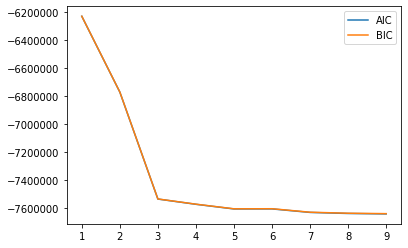

In [5]:
NumCLusterLst = list(range(1,NumClustersVal))
plt.plot(NumCLusterLst, AIC, label="AIC")
plt.plot(NumCLusterLst, BIC, label="BIC")
plt.legend()

In [6]:
SaveCompositionClusters(VoxRatioFile=Vox_ratio_file_name, VoxFile =Small_chunk_file_name, OutFile =Vox_centroid_file_to_make_name,n_components = 10)

100%|██████████| 23144/23144 [00:33<00:00, 693.41it/s] 


In [6]:
def VoxRead(VoxFile, FilesArr):
    with h5py.File(VoxFile,"r") as hdf:
        #group = hdf.get("Group_sm_vox_xyz_Da_spec")
        #spec_lst = list(list(group.attrs.values())[1])
        items = list(hdf.items())
        item_lst = []
        for item in range(len(items)):
            item_lst.append([100000*(item),100000*(item+1)])
        item_lst = np.array(item_lst)


        Dic_centroids = {}
        Dic_centroids["x"]=[]
        Dic_centroids["y"]=[]
        Dic_centroids["z"] = []
        Dic_centroids["file_name"] = []
        Df_centroids = pd.DataFrame(columns=['x', 'y', 'z','filename'])
        for filename in tqdm(FilesArr):
            #file_name_grp = "Group_sm_vox_xyz_Da_spec/"+"{}".format(int(i))
            group = np.min(item_lst[[filename in range(j[0],j[1]) for j in item_lst]])
            xyz_Da_spec_atoms = np.array(hdf.get("{}/{}".format(group,filename)))
            x,y,z = centeroid_np_array(xyz_Da_spec_atoms)
            Dic_centroids["x"].append(x)
            Dic_centroids["y"].append(y)
            Dic_centroids["z"].append(z)
            Dic_centroids["file_name"].append(filename)
            #Df_centroids = Df_centroids.append({'x': x, 'y': y, 'z': z, 'filename' : i}, ignore_index=True)
            
    return Dic_centroids

In [80]:
def CompositionCluster(VoxRatioFile, VoxFile, n_components):
    
    PCACumsumArr, Ratios = PCA_cumsum(VoxRatioFile, VoxFile )
    X = Ratios.drop(['Total_no','vox'], axis=1)
    
    gm = GaussianMixture(n_components=3, max_iter=100000,verbose=0)
    gm.fit(X)
    y_pred=gm.predict(X)
    
    cluster_0 = np.argwhere(y_pred == 0)
    cluster_1 = np.argwhere(y_pred == 1)
    cluster_2 = np.argwhere(y_pred == 2)
    
    df_dis2 = Ratios.iloc[cluster_2.flatten()]
    df_dis1 = Ratios.iloc[cluster_1.flatten()]
    df_dis0 = Ratios.iloc[cluster_0.flatten()]
    return df_dis2, df_dis1,df_dis0, cluster_0,cluster_1,cluster_2,Ratios
    
def SaveCompositionClusters(VoxRatioFile, VoxFile, OutFile,n_components):
    df_dis2, df_dis1,df_dis0, cluster_0,cluster_1,cluster_2,Ratios = CompositionCluster(VoxRatioFile, VoxFile, n_components)
    
    plot_files_cl_0 = []
    plot_files_cl_1 = []
    plot_files_cl_2 = []

    #for i in cluster_2.flatten():
    #    plot_files_cl_2.append(Ratios['filename'][i])

    for i in cluster_0.flatten():
        plot_files_cl_0.append(Ratios['vox'][i])
    for i in cluster_1.flatten():
        plot_files_cl_1.append(Ratios['vox'][i])

    for i in cluster_2.flatten():
        plot_files_cl_2.append(Ratios['vox'][i])
        
        
    #get the item name for h5 file
    plot_files_cl_0_group = [int(file_num) for file_num in plot_files_cl_0 ]
    plot_files_cl_1_group = [int(file_num) for file_num in plot_files_cl_1 ]
    plot_files_cl_2_group = [int(file_num) for file_num in plot_files_cl_2 ]
    
    hdfw = h5py.File(OutFile,"w")

    G1 = hdfw.create_group("All")
    G1.attrs["what"] = ["Centroid of All voxels"]
    G1.attrs["howto_Group_name"] = ["Group_sm_vox_xyz_Da_spec/"]
    G1.attrs["colomns"] = ["x","y","z","file_name"]

    G2 = hdfw.create_group("Phase1")
    G2.attrs["what"] = ["Centroid of Phase1 voxels"]
    G2.attrs["howto_Group_name"] = ["Group_sm_vox_xyz_Da_spec/"]
    G2.attrs["colomns"] = ["x","y","z","file_name"]

    G3 = hdfw.create_group("Phase2")
    G3.attrs["what"] = ["Centroid of Phase2 voxels"]
    G3.attrs["howto_Group_name"] = ["Group_sm_vox_xyz_Da_spec/"]
    G3.attrs["colomns"] = ["x","y","z","file_name"]
    
    
    ##All
    import os
    #Small_chunk_file_name = "./file_file_D3_High_Hc_R5076_53143_apt_large_chunks_test_arr_h5_small_chunks_test_arr4.h5"
    hdf_sm_r = h5py.File(Small_chunk_file_name,"r")
    group = hdf_sm_r.get("0")
    Total_Voxels =list(list(group.attrs.values())[0])

    Total_Voxels_int =""
    for number in Total_Voxels:
        Total_Voxels_int = Total_Voxels_int+ number

    Total_Voxels_int = int(Total_Voxels_int)
    hdf_sm_r.close()
    plot_files_cl_All_group = [file_num for file_num in range(Total_Voxels_int)]
    #files = [file_num for file_num in range(905667)]

    FilesList = [plot_files_cl_All_group, plot_files_cl_1_group, plot_files_cl_2_group]
    GroupsList = [G1,G2,G3]
    PhasesNames = ["All","Ph1", "Ph2"] 
    
    for i in range(len(FilesList)):
        
        CentroidsDic = VoxRead(VoxFile, FilesArr= FilesList[i])
        GroupsList[i].create_dataset("{}".format(PhasesNames[i]), data = pd.DataFrame.from_dict(CentroidsDic).values)
    hdfw.close()

NameError: name 'GaussianMixture' is not defined

In [82]:

with h5py.File(Vox_centroid_file_to_make_name , "r") as hdfr:
    Phase2_cent_arr = np.array(hdfr.get("Phase1/Phase1_centroids"))
    group2 = hdfr.get("Phase1")
    Phase2_cent_columns = list(list(group2.attrs.values())[0])
    #Group_name = list(list(hdfr.attrs.values())[1])
Phase2_cent =pd.DataFrame(data=Phase2_cent_arr, columns=Phase2_cent_columns)
Phase2_cent.head()
len(Phase2_cent)

42167

In [83]:
from pyevtk.hl import pointsToVTK
from pyevtk.hl import gridToVTK#, pointsToVTKAsTIN

Df_comb = Phase2_cent
image = Df_comb.values
FILE_PATH1 = "./Ph1_raw_cent_D1"
x = np.ascontiguousarray(image[:,0])
y= np.ascontiguousarray(image[:,1])
z = np.ascontiguousarray(image[:,2])
label = np.ascontiguousarray( image[:,3])
pointsToVTK(FILE_PATH1,x,y,z, data = {"label" : label}  )

'/talos/u/gazal/APT_calculations/for_nikita_Sm_Zr_Cu_Fe/20220613_APT_NFDI/Ph1_raw_cent_D1.vtu'

# Read the file voxel ratio file:( 3_Vox_ratios_D3.csv)

In [15]:
Small_chunk_file_name = "file_file_D1 High Hc R5076_52126_apt_large_chunks_test_arr_h5_small_chunks_test_arr4.h5"
Vox_centroid_file_to_make_name = "3_Vox_centroids_D3_Mr_Grp.h5"
Vox_ratio_file_name="3Vox_ratios_filenames_num_MR_Grp.h5"

In [19]:
PCA_cumsum, Ratios = PCA_cumsum(VoxRatioFile=Vox_ratio_file_name, VoxFile =Small_chunk_file_name)

TypeError: 'numpy.ndarray' object is not callable

In [17]:
PCA_cumsum

array([0.5116405 , 0.86487543, 0.95748953, 1.        , 1.        ])

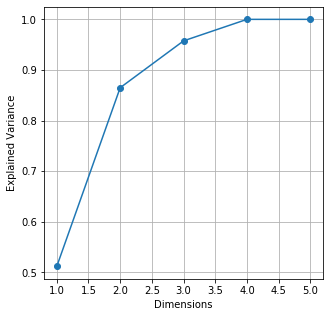

In [18]:
plt.figure(figsize=(5,5))
plt.plot( range(1,6,1),PCA_cumsum,"-o")
plt.ylabel("Explained Variance")
plt.xlabel('Dimensions')
plt.grid()

In [9]:
with h5py.File(Small_chunk_file_name,"r") as hdf:
    group = hdf.get("Group_sm_vox_xyz_Da_spec")
    group0 = hdf.get("0")
    spec_lst = list(list(group0 .attrs.values())[2])
print(spec_lst)

['Co:1', 'Cu:1', 'Fe:1', 'Sm:1', 'Zr:1']


In [10]:
with h5py.File(Vox_ratio_file_name , "r") as hdfr:
    Ratios = np.array(hdfr.get("vox_ratios"))
    Ratios_colomns = list(list(hdfr.attrs.values())[0])
    Group_name = list(list(hdfr.attrs.values())[1])


In [11]:
#convert to Vox ratios to pandas dataframe
Ratios =pd.DataFrame(data=Ratios, columns=Ratios_colomns)
Ratios.values.shape


(238395, 7)

In [12]:
Ratios.head()

,0.0,1.0,2.0,3.0,4.0,Total_no,vox
0,0.495238,0.180952,0.209524,0.104762,0.009524,105.0,0.0
1,0.446078,0.240196,0.176471,0.137255,0.000000,204.0,1.0
2,0.476190,0.206349,0.174603,0.142857,0.000000,189.0,2.0
3,0.557522,0.035398,0.247788,0.159292,0.000000,113.0,3.0
4,0.662651,0.000000,0.301205,0.036145,0.000000,83.0,4.0


In [14]:
Ratios.head()

,0.0,1.0,2.0,3.0,4.0,Total_no,vox
0,0.495238,0.180952,0.209524,0.104762,0.009524,105.0,0.0
1,0.446078,0.240196,0.176471,0.137255,0.000000,204.0,1.0
2,0.476190,0.206349,0.174603,0.142857,0.000000,189.0,2.0
3,0.557522,0.035398,0.247788,0.159292,0.000000,113.0,3.0
4,0.662651,0.000000,0.301205,0.036145,0.000000,83.0,4.0


# Apply PCA to visaulise the concentration space

In [15]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import manifold

In [24]:
X_train=Ratios.drop(['Total_no','vox'], axis=1)
PCAObj = PCA(n_components = len(spec_lst)) 
PCATrans = PCAObj.fit_transform(X_train)
#pca.explained_variance_ratio_
PCAObj.explained_variance_
cumsum = np.cumsum(PCAObj.explained_variance_ratio_)
len(cumsum)

5

In [26]:
cumsum

array([0.5116405 , 0.86487543, 0.95748953, 1.        , 1.        ])

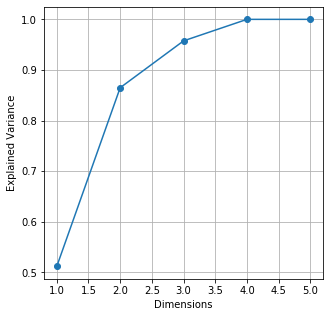

In [25]:

plt.figure(figsize=(5,5))
plt.plot( range(1,6,1),cumsum,"-o")
plt.ylabel("Explained Variance")
plt.xlabel('Dimensions')
plt.grid()

In [14]:
pca = PCA(n_components = 3)
X_reduced = pca.fit_transform(X_train)
(X_reduced.shape)

(238395, 3)

In [15]:
PCA_D4_frame=pd.DataFrame(X_reduced, columns=['D_1','D_2','D_3'])

Text(0.5, 0, 'D2')

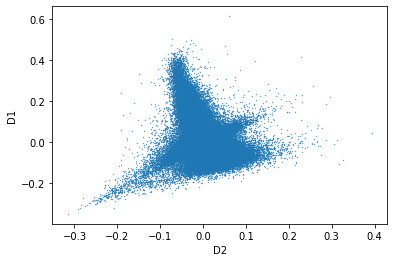

In [16]:
plt.scatter(PCA_D4_frame['D_3'],PCA_D4_frame['D_2'],s=0.1,marker='o')
plt.ylabel("D1")
plt.xlabel('D2')

# Clustering in the concentration space using Gaussian mixture models

In [27]:
X = X_train


In [28]:
#import tqdm
gm_scores=[]
aics=[]
bics=[]
X = X_train
n_clusters=list(range(1,10))
for n_cluster in tqdm(n_clusters):
    gm = GaussianMixture(n_components=n_cluster,verbose=0)
    gm.fit(X)
    y_pred=gm.predict(X)
    #gm_scores.append(homogeneity_score(y,y_pred))
    aics.append(gm.aic(X))
    bics.append(gm.bic(X))

100%|██████████| 9/9 [00:35<00:00,  3.90s/it]


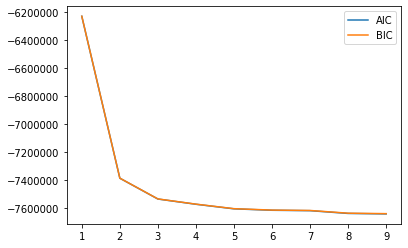

In [29]:
plt.plot(n_clusters,aics,label="AIC")
plt.plot(n_clusters,bics,label="BIC")
plt.legend()

In [37]:
gm = GaussianMixture(n_components=3, max_iter=100000,verbose=0)
gm.fit(X)
y_pred=gm.predict(X)

In [38]:
y_pred

array([2, 2, 2, ..., 1, 1, 1])

In [39]:
cluster_1 = np.argwhere(y_pred == 1)
cluster_0 = np.argwhere(y_pred == 0)
cluster_2 = np.argwhere(y_pred == 2)

print(len(cluster_0), len(cluster_1),  len(cluster_2))

173076 42167 23152


In [40]:
df_dis2 = Ratios.iloc[cluster_2.flatten()]
df_dis1 = Ratios.iloc[cluster_1.flatten()]
df_dis0 = Ratios.iloc[cluster_0.flatten()]

In [41]:
spec_lst

['Co:1', 'Cu:1', 'Fe:1', 'Sm:1', 'Zr:1']

In [42]:
df_dis1

,0.0,1.0,2.0,3.0,4.0,Total_no,vox
5,0.462687,0.000000,0.358209,0.164179,0.014925,67.0,5.0
6,0.617978,0.011236,0.235955,0.112360,0.022472,89.0,6.0
8,0.661538,0.038462,0.246154,0.053846,0.000000,130.0,8.0
11,0.561798,0.044944,0.258427,0.101124,0.033708,89.0,11.0
13,0.631579,0.000000,0.184211,0.184211,0.000000,38.0,13.0
...,...,...,...,...,...,...,...
238390,0.568627,0.019608,0.196078,0.039216,0.176471,51.0,238390.0
238391,0.766667,0.000000,0.100000,0.066667,0.066667,30.0,238391.0
238392,0.485714,0.000000,0.171429,0.200000,0.142857,35.0,238392.0
238393,0.484848,0.000000,0.181818,0.181818,0.151515,33.0,238393.0


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


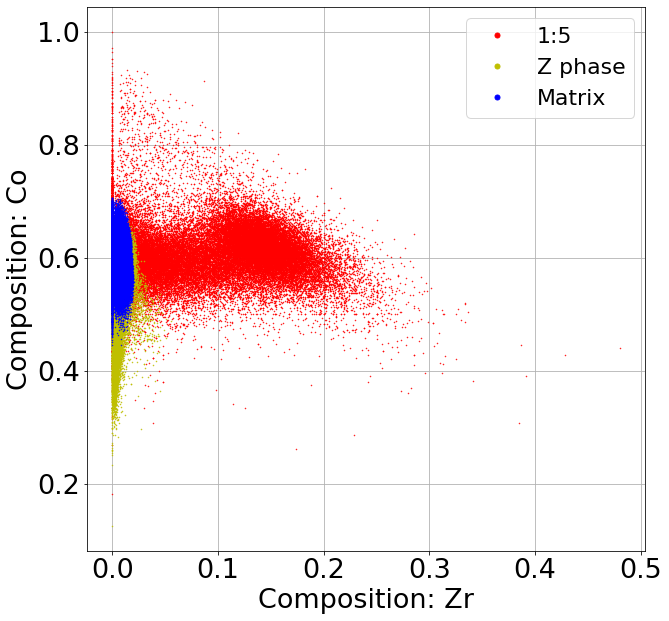

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


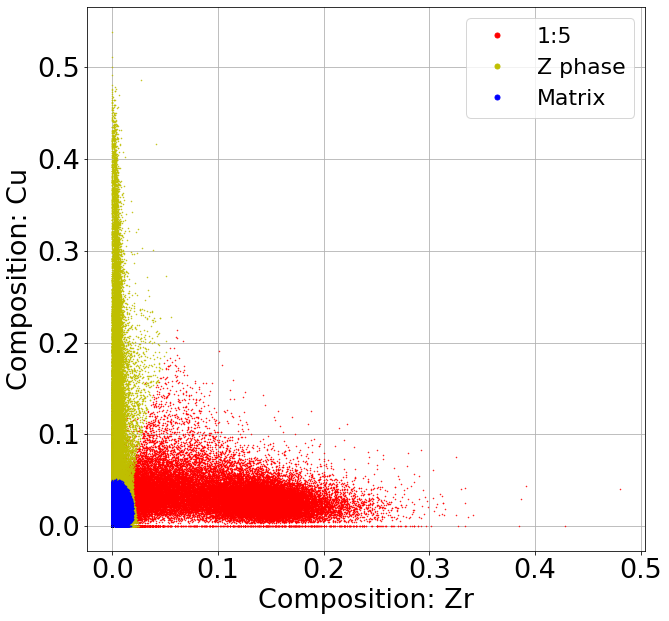

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


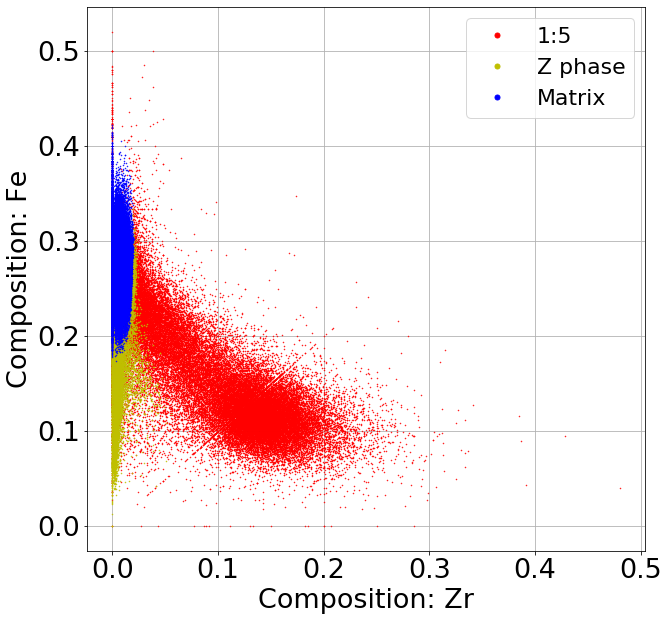

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


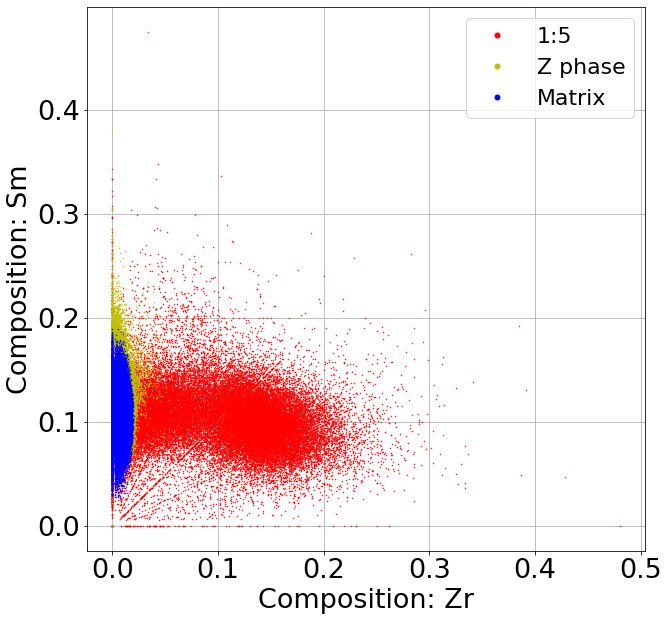

In [43]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 27})
spec = ["Co","Cu", "Fe", "Sm"]
for i in range(4):
    plt.plot (df_dis1["4.0"],df_dis1["{}.0".format(int(i))], "o", color='r',markersize = 0.5, label = "1:5")
    plt.plot (df_dis2["4.0"],df_dis2["{}.0".format(int(i))],"o", color='y' ,markersize = 0.5, label = "Z phase" )
    plt.plot (df_dis0["4.0"],df_dis0["{}.0".format(int(i))],"o", color='b' ,markersize = 0.5,label = "Matrix" )

    plt.xlabel("Composition: Zr")
    plt.ylabel("Composition: {}".format(spec[i]))
    plt.legend(markerscale =10,fontsize =22)
    plt.grid()
    plt.show()

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


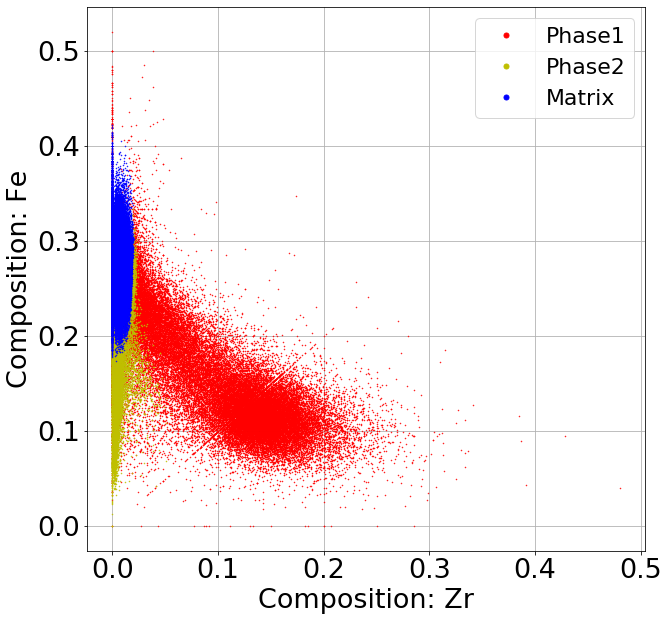

In [44]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 27})
plt.plot (df_dis1["4.0"],df_dis1["2.0"], "o", color='r',markersize = 0.5, label = "Phase1")
plt.plot (df_dis2["4.0"],df_dis2["2.0"],"o", color='y' ,markersize = 0.5, label = "Phase2" )
plt.plot (df_dis0["4.0"],df_dis0["2.0"],"o", color='b' ,markersize = 0.5,label = "Matrix" )

plt.xlabel("Composition: Zr")
plt.ylabel("Composition: Fe")
plt.legend(markerscale =10,fontsize =22)
plt.grid()

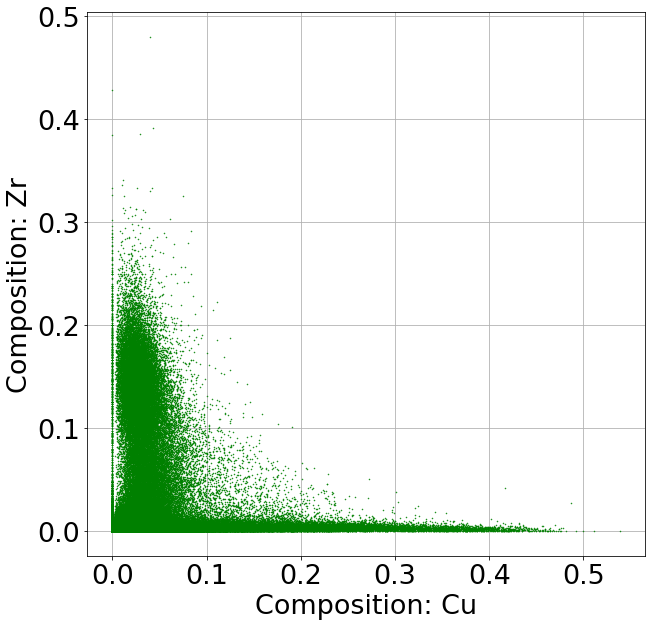

In [45]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 27})
plt.plot (df_dis1["1.0"],df_dis1["4.0"], "o", color='g',markersize = 0.5, label = "Phase1")
plt.plot (df_dis2["1.0"],df_dis2["4.0"],"o", color='g' ,markersize = 0.5, label = "Phase2" )
plt.plot (df_dis0["1.0"],df_dis0["4.0"],"o", color='g' ,markersize = 0.5,label = "Matrix" )

plt.xlabel("Composition: Cu")
plt.ylabel("Composition: Zr")
#plt.legend(markerscale =10,fontsize =22)
plt.grid()

In [29]:
"""
a = np.argwhere(df_dis1["ratio_Zr"].values < 0.064 )
b = np.argwhere(df_dis1["ratio_Zr"].values > 0.058 )
phase = np.intersect1d(a.flatten(), b.flatten())
Df_phase = df_dis1.iloc[phase]
Df_phase
""";

# Clustering with concentration space information

In [46]:
plot_files_cl_0 = []
plot_files_cl_1 = []
plot_files_cl_2 = []

#for i in cluster_2.flatten():
#    plot_files_cl_2.append(Ratios['filename'][i])

for i in cluster_0.flatten():
    plot_files_cl_0.append(Ratios['vox'][i])
for i in cluster_1.flatten():
    plot_files_cl_1.append(Ratios['vox'][i])

for i in cluster_2.flatten():
    plot_files_cl_2.append(Ratios['vox'][i])

In [47]:
#get the item name for h5 file
plot_files_cl_0_group = [int(file_num) for file_num in plot_files_cl_0 ]
plot_files_cl_1_group = [int(file_num) for file_num in plot_files_cl_1 ]
plot_files_cl_2_group = [int(file_num) for file_num in plot_files_cl_2 ]

In [48]:
hdfw = h5py.File(Vox_centroid_file_to_make_name,"w")

G1 = hdfw.create_group("All")
G1.attrs["what"] = ["Centroid of All voxels"]
G1.attrs["howto_Group_name"] = ["Group_sm_vox_xyz_Da_spec/"]
G1.attrs["colomns"] = ["x","y","z","file_name"]

G2 = hdfw.create_group("Phase1")
G2.attrs["what"] = ["Centroid of Phase1 voxels"]
G2.attrs["howto_Group_name"] = ["Group_sm_vox_xyz_Da_spec/"]
G2.attrs["colomns"] = ["x","y","z","file_name"]

G3 = hdfw.create_group("Phase2")
G3.attrs["what"] = ["Centroid of Phase2 voxels"]
G3.attrs["howto_Group_name"] = ["Group_sm_vox_xyz_Da_spec/"]
G3.attrs["colomns"] = ["x","y","z","file_name"]

In [49]:
with h5py.File(Small_chunk_file_name,"r") as hdf:
    #group = hdf.get("Group_sm_vox_xyz_Da_spec")
    #spec_lst = list(list(group.attrs.values())[1])
    items = list(hdf.items())
    item_lst = []
    for item in range(len(items)):
        item_lst.append([100000*(item),100000*(item+1)])
    item_lst = np.array(item_lst)
    
    
    Dic_centroids = {}
    Dic_centroids["x"]=[]
    Dic_centroids["y"]=[]
    Dic_centroids["z"] = []
    Dic_centroids["file_name"] = []
    Df_centroids = pd.DataFrame(columns=['x', 'y', 'z','filename'])
    for filename in tqdm(plot_files_cl_1_group):
        #file_name_grp = "Group_sm_vox_xyz_Da_spec/"+"{}".format(int(i))
        group = np.min(item_lst[[filename in range(j[0],j[1]) for j in item_lst]])
        xyz_Da_spec_atoms = np.array(hdf.get("{}/{}".format(group,filename)))
        x,y,z = centeroid_np_array(xyz_Da_spec_atoms)
        Dic_centroids["x"].append(x)
        Dic_centroids["y"].append(y)
        Dic_centroids["z"].append(z)
        Dic_centroids["file_name"].append(filename)
        #Df_centroids = Df_centroids.append({'x': x, 'y': y, 'z': z, 'filename' : i}, ignore_index=True)

100%|██████████| 42167/42167 [02:02<00:00, 344.32it/s] 


In [50]:
#pd.DataFrame.from_dict(Dic_centroids).to_csv("D3_preci_cent_file_num_MR_GRP.csv",index = False)

In [51]:
#pd.DataFrame.from_dict(Dic_centroids).head()

In [52]:
pd.DataFrame.from_dict(Dic_centroids)

,x,y,z,file_name
0,-2.000332,-58.089706,-264.444145,5
1,0.074125,-58.074836,-264.542926,6
2,4.056624,-58.056500,-264.437410,8
3,9.918218,-57.621544,-264.633343,11
4,13.776727,-57.186880,-264.926647,13
...,...,...,...,...
42162,2.772018,4.924755,-0.756297,238390
42163,4.689398,4.813485,-0.846640,238391
42164,-2.803172,6.503012,-0.879646,238392
42165,-0.867378,6.608317,-0.848996,238393


In [53]:
G2.create_dataset("Phase1_centroids", data = pd.DataFrame.from_dict(Dic_centroids).values)

<HDF5 dataset "Phase1_centroids": shape (42167, 4), type "<f8">

In [54]:
with h5py.File(Small_chunk_file_name,"r") as hdf:
    #group = hdf.get("Group_sm_vox_xyz_Da_spec")
    #spec_lst = list(list(group.attrs.values())[1])
    items = list(hdf.items())
    item_lst = []
    for item in range(len(items)):
        item_lst.append([100000*(item),100000*(item+1)])
    item_lst = np.array(item_lst)
    
    Dic_centroids = {}
    Dic_centroids["x"]=[]
    Dic_centroids["y"]=[]
    Dic_centroids["z"] = []
    Dic_centroids["file_name"] = []
    Df_centroids = pd.DataFrame(columns=['x', 'y', 'z','filename'])
    for filename in tqdm(plot_files_cl_2_group):
        #file_name_grp = "Group_sm_vox_xyz_Da_spec/"+"{}".format(int(i))
        group = np.min(item_lst[[filename in range(j[0],j[1]) for j in item_lst]])
        xyz_Da_spec_atoms = np.array(hdf.get("{}/{}".format(group,filename)))
        #xyz_Da_spec_atoms = np.array(hdf.get(i))
        x,y,z = centeroid_np_array(xyz_Da_spec_atoms)
        Dic_centroids["x"].append(x)
        Dic_centroids["y"].append(y)
        Dic_centroids["z"].append(z)
        Dic_centroids["file_name"].append(filename)
        #Df_centroids = Df_centroids.append({'x': x, 'y': y, 'z': z, 'filename' : i}, ignore_index=True)

100%|██████████| 23152/23152 [00:25<00:00, 913.19it/s] 


In [55]:
#pd.DataFrame.from_dict(Dic_centroids).to_csv("D3_preci_cent_file_num_phase_2_MR_GRP.csv",index = False)

In [56]:
#pd.DataFrame.from_dict(Dic_centroids).head()

In [57]:
pd.DataFrame.from_dict(Dic_centroids)

,x,y,z,file_name
0,-11.855699,-57.253846,-264.615539,0
1,-9.954283,-57.498826,-264.624768,1
2,-8.140639,-57.661391,-264.488740,2
3,7.965592,-57.814886,-264.527164,10
4,-12.034681,-56.558273,-264.400588,18
...,...,...,...,...
23147,-8.982626,-8.954417,-4.301029,237983
23148,-7.008265,-8.909562,-4.261717,237984
23149,-5.034825,-8.965411,-4.266497,237985
23150,-10.977636,-7.061451,-4.363105,237999


In [58]:
len(pd.DataFrame.from_dict(Dic_centroids).values)

23152

In [59]:
G3.create_dataset("Phase2_centroids", data = pd.DataFrame.from_dict(Dic_centroids).values)

<HDF5 dataset "Phase2_centroids": shape (23152, 4), type "<f8">

In [60]:
##All
import os
#Small_chunk_file_name = "./file_file_D3_High_Hc_R5076_53143_apt_large_chunks_test_arr_h5_small_chunks_test_arr4.h5"
hdf_sm_r = h5py.File(Small_chunk_file_name,"r")
group = hdf_sm_r.get("0")
Total_Voxels =list(list(group.attrs.values())[0])

Total_Voxels_int =""
for number in Total_Voxels:
    Total_Voxels_int = Total_Voxels_int+ number
    
Total_Voxels_int = int(Total_Voxels_int)
hdf_sm_r.close()
plot_files_cl_All_group = [file_num for file_num in range(Total_Voxels_int)]
#files = [file_num for file_num in range(905667)]

In [61]:
with h5py.File(Small_chunk_file_name,"r") as hdf:
    #group = hdf.get("Group_sm_vox_xyz_Da_spec")
    #spec_lst = list(list(group.attrs.values())[1])
    items = list(hdf.items())
    item_lst = []
    for item in range(len(items)):
        item_lst.append([100000*(item),100000*(item+1)])
    item_lst = np.array(item_lst)
    
    Dic_centroids = {}
    Dic_centroids["x"]=[]
    Dic_centroids["y"]=[]
    Dic_centroids["z"] = []
    Dic_centroids["file_name"] = []
    Df_centroids = pd.DataFrame(columns=['x', 'y', 'z','filename'])
    for filename in tqdm(plot_files_cl_All_group):
        #file_name_grp = "Group_sm_vox_xyz_Da_spec/"+"{}".format(int(i))
        group = np.min(item_lst[[filename in range(j[0],j[1]) for j in item_lst]])
        xyz_Da_spec_atoms = np.array(hdf.get("{}/{}".format(group,filename)))
        #xyz_Da_spec_atoms = np.array(hdf.get(i))
        x,y,z = centeroid_np_array(xyz_Da_spec_atoms)
        Dic_centroids["x"].append(x)
        Dic_centroids["y"].append(y)
        Dic_centroids["z"].append(z)
        Dic_centroids["file_name"].append(filename)

100%|██████████| 238395/238395 [01:43<00:00, 2295.39it/s]


In [62]:
#pd.DataFrame.from_dict(Dic_centroids).to_csv("D3_preci_cent_file_num_phase_mat.csv",index = False)

In [63]:
G1.create_dataset("All", data = pd.DataFrame.from_dict(Dic_centroids).values)

<HDF5 dataset "All": shape (238395, 4), type "<f8">

In [64]:
hdfw.close()

In [ ]:
####

In [65]:

with h5py.File(Vox_centroid_file_to_make_name , "r") as hdfr:
    Phase2_cent_arr = np.array(hdfr.get("Phase1/Phase1_centroids"))
    group2 = hdfr.get("Phase1")
    Phase2_cent_columns = list(list(group2.attrs.values())[0])
    #Group_name = list(list(hdfr.attrs.values())[1])
Phase2_cent =pd.DataFrame(data=Phase2_cent_arr, columns=Phase2_cent_columns)
Phase2_cent.head()
len(Phase2_cent)

42167

In [66]:
Phase2_cent

,x,y,z,file_name
0,-2.000332,-58.089706,-264.444145,5.0
1,0.074125,-58.074836,-264.542926,6.0
2,4.056624,-58.056500,-264.437410,8.0
3,9.918218,-57.621544,-264.633343,11.0
4,13.776727,-57.186880,-264.926647,13.0
...,...,...,...,...
42162,2.772018,4.924755,-0.756297,238390.0
42163,4.689398,4.813485,-0.846640,238391.0
42164,-2.803172,6.503012,-0.879646,238392.0
42165,-0.867378,6.608317,-0.848996,238393.0


In [67]:
from pyevtk.hl import pointsToVTK
from pyevtk.hl import gridToVTK#, pointsToVTKAsTIN

Df_comb = Phase2_cent
image = Df_comb.values
FILE_PATH1 = "./Ph1_raw_cent_D1"
x = np.ascontiguousarray(image[:,0])
y= np.ascontiguousarray(image[:,1])
z = np.ascontiguousarray(image[:,2])
label = np.ascontiguousarray( image[:,3])
pointsToVTK(FILE_PATH1,x,y,z, data = {"label" : label}  )

'/talos/u/gazal/APT_calculations/for_nikita_Sm_Zr_Cu_Fe/20220613_APT_NFDI/Ph1_raw_cent_D1.vtu'

In [ ]:
####################################